# Introduction 

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

# Load and check data

## Load data

In [88]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
IDtest = test['PassengerId']

## Outlier detection

In [89]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile(75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range(IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices more than 2 outliers
        outlier_indices.extend(outlier_list_col)
    
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers
    # detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train,2,['Age', 'SibSp', 'Parch', 'Fare'])

아웃라이어가 예측에 큰 영향을 미칠 수 있기 때문에, Tukey method(Tukey JW. 1977)을 사용하여 아웃라이어를 찾습니다. IQR 에서 outlier step만큼 떨어져 있을 시 아웃라이어로 판정합니다.

데이터의 수치형 피처에서 아웃라이어를 찾습니다. 

In [90]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 아웃라이어를 찾았습니다. 27, 88, 341번 승객은 높은 티켓 요금을 지불했고 나머지 7명은 많은 SibSP을 가지고 있습니다.

In [91]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## joining train and test set

In [92]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

훈련용과 검증용 데이터셋을 조인시켜 추후 피처 엔지니어링에서 같은 수의 피처를 얻게 했습니다.

##  check for null and missing values

In [93]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

#check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin 피처가 많은 결측값을 가지고 있습니다.

Survived는 테스트 데이터셋을 조인시켜 NaN값이 생긴 것입니다.

In [94]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [95]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [96]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [97]:
### Summarize data
# Summary and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

## Numerical values

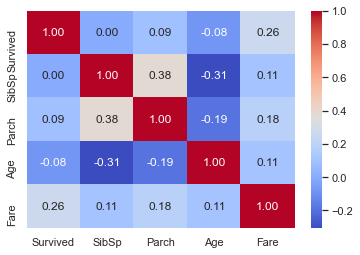

In [98]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

오직 Fare 피처만 생존율과 관련이 있어 보입니다.

다른 피처는 유용하지 않아보입니다. 좀더 자세하게 살펴보겠습니다.

### SibSp

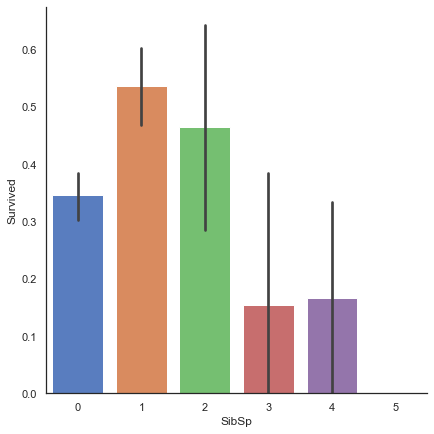

In [99]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x = 'SibSp', y='Survived', data = train, kind='bar', size=6, palette='muted')

탑승객이 많은 형제자매나 배우자를 태우고 탈수록 생존율이 감소합니다.

혼자 탑승한 사람 또는 두명과 탄사람은 생존율이 높습니다.

### Parch

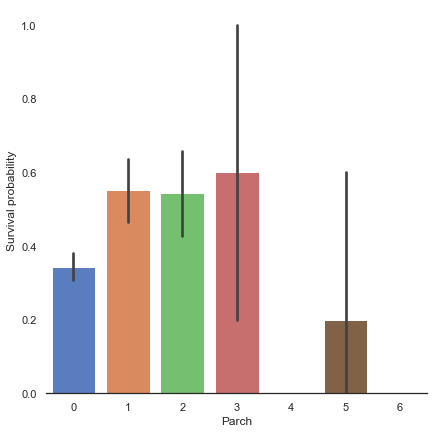

In [100]:
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

가족이 3명 이하일때 생존율이 혼자일때보다 높습니다.

### Age

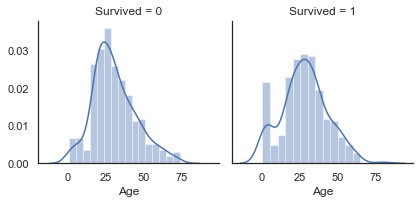

In [101]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

 생존자와 사망자의 나이 분포가 같지 않습니다. 게다가 생존자 중 어린 탑승객의 생존율이 매우 높게 나타납니다. 60-80세의 탑승객의 생존율은 낮습니다.
 
Age가 생존율과 상관관계가 없다 해도, 생존 가능성이 존재하는 승객의 연령 범주가 있음을 알 수 있습니다.

아주 어린 승객들은 생존할 수 있는 더 많은 기회를 가지고 있습니다.

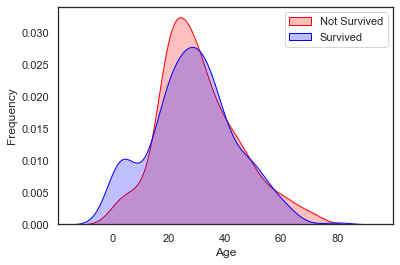

In [102]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두 그래프를 비교했을 때, 0-5세 사이에서 생존율이 높게 나옴을 알 수 있습니다.

### Fare

In [103]:
dataset['Fare'].isnull().sum()

1

In [104]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

하나의 결측값을 중위수로 채웠습니다.

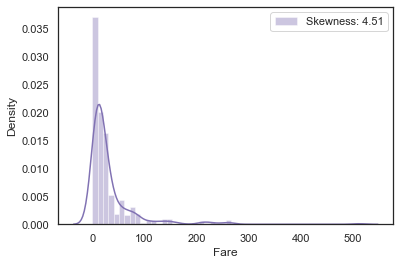

In [105]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

Fare의 분포는 매우 좌측으로 편향되어 있습니다. 따라서 이를 조정하기 위해 Fare에 log를 취해 skew을 낮추겠습니다.

In [106]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

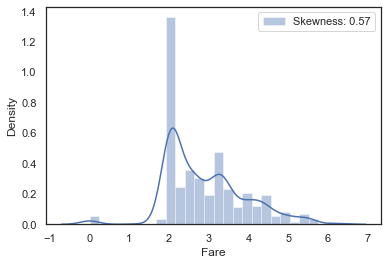

In [107]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

skew가 매우 크게 감소한 것을 볼 수 있습니다.

## Categorical values

### Sex

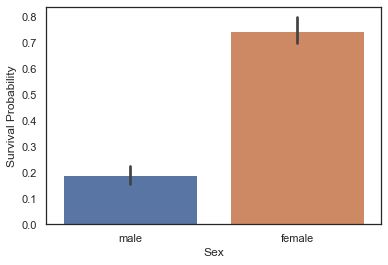

In [108]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [109]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자가 여자보다 생존율이 매우 작습니다.

생존을 예측할 때 성별은 매우 중요한 피처가 될 것 같습니다.

### Pclass

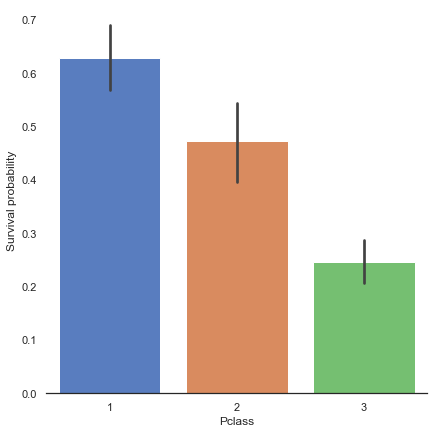

In [110]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar',size=6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

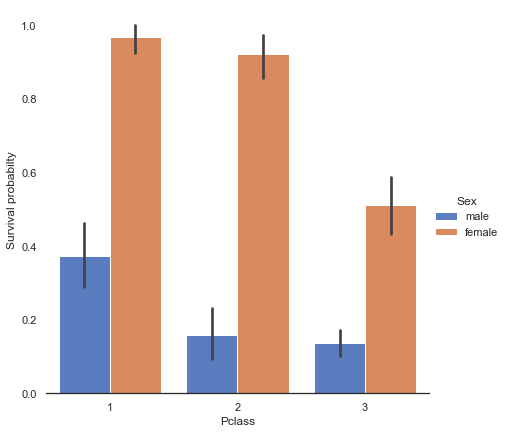

In [111]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probabilty')

클래스1의 승객이 남여 모두 생존율이 가장 높습니다.

### Embarked

In [112]:
dataset['Embarked'].isnull().sum()

2

In [113]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [114]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

2개의 결측치를 가장 많이 관측된 S로 채웠습니다.

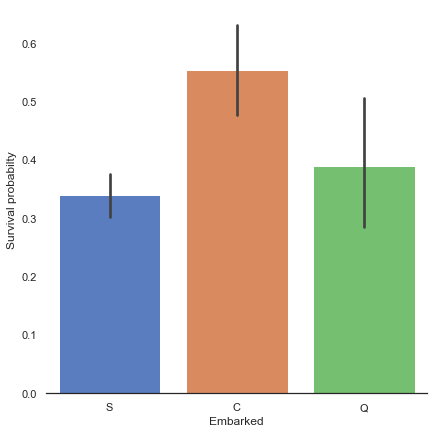

In [115]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probabilty')